<a href="https://colab.research.google.com/github/allenthemartian/CNN/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine Tuning

In the previous notebook, we've covered Transfer Learning Feature Extraction, now it's time to learn about a new kind of Transfer Learning: Fine Tuning.

In [ ]:
from google.colab.output import eval_js
def set_cell_size(height=250):
  height = str(height)
  return eval_js(f"google.colab.output.setIframeHeight({height})")

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Wed Sep 15 06:48:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.  

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).  

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-16 06:08:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-16 06:08:45 (60.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when the **runtime** times out, Colab will delete `helper_functions.py`. You'll have to redownload it if you want access to your helper functions.  

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognising images of Food).  

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications




In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data(filename="10_food_classes_10_percent.zip")

--2021-09-15 06:49:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2021-09-15 06:49:01 (174 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

`image_dataset_from_directory` - Has turned our data into batches.  

`None` - Adds another dimension to denote the batches.  

**Labels** are **one-hot-encoded** versions of our 10 classes.

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
set_cell_size(300)
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[205.5       123.5        41.5      ]
   [206.52042   123.52041    43.520405 ]
   [205.91837   123.13265    47.637753 ]
   ...
   [250.65309   254.49495   243.21432  ]
   [245.4694    252.22961   241.87248  ]
   [249.21425   254.87244   246.21425  ]]

  [[205.90306   123.90306    39.903057 ]
   [204.65816   122.591835   40.724487 ]
   [210.37245   127.58673    50.15816  ]
   ...
   [252.3265    255.        244.12755  ]
   [253.3163    254.86736   245.59183  ]
   [245.80608   252.52043   240.20918  ]]

  [[207.77042   126.19898    39.55612  ]
   [204.68877   123.11735    38.87245  ]
   [210.49489   129.49489    48.32653  ]
   ...
   [251.29582   252.53055   242.29582  ]
   [253.11731   254.92856   243.11731  ]
   [247.79106   252.29097   239.3625   ]]

  ...

  [[216.89246   123.67819    31.320982 ]
   [209.22403   116.00977    23.652563 ]
   [203.14775   108.101845   18.239584 ]
   ...
   [ 48.168354   21.168354    4.168355 ]
   [ 46.41322    19.413221    2.4132204]
   [ 

# Keras Sequential vs Functional API  

* Similarities: **compiling, fitting, evaluating**  
* Differences: *Model Construction*: (the **Functional API is more flexible** and able to produce more sophisticated models)

## Model 0: Building a transfer learning Feature Extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models. - https://www.tensorflow.org/guide/keras/functional



______________________________________

Pass in the `(x)` layer as a function call at the tail end of the **new layer** to call the **previously stored layer.**  

1. Create the `inputs` layers  
2. Use the **Functional API** technique for all **hidden layers** `(x)`.  
3. Create the `outputs` layers also calling **previously defined layers** using the **Functional API** technique.  
4. Combine the `inputs` and the **layered** `outputs` into a model.

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patters aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using model like ResNet50V2 you WILL need to normalize inputs (you don't have to for EfficientNet(s))
# In Sequential API we need to rescale using ImageDataGenerator,
# in Functional API we can put this layer directly into the model
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")],
                                 validation_data=test_data,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_steps=int(0.25 * len(test_data)))

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210915-064922


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 51s 520ms/step - loss: 1.9140 - accuracy: 0.3973 - val_loss: 1.3793 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 10s 377ms/step - loss: 1.1611 - accuracy: 0.7387 - val_loss: 0.9437 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - 9s 357ms/step - loss: 0.8406 - accuracy: 0.8053 - val_loss: 0.7656 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - 8s 308ms/step - loss: 0.6959 - accuracy: 0.8227 - val_loss: 0.6946 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 8s 301ms/step - loss: 0.6007 - accuracy: 0.8467 - val_loss: 0.6306 - val_accuracy: 0.8322


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 11s 136ms/step - loss: 0.6133 - accuracy: 0.8376


[0.6133062243461609, 0.8375999927520752]

In [ ]:
set_cell_size(300)
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
set_cell_size()
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


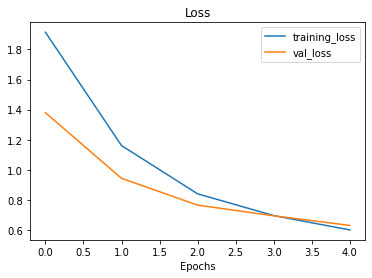

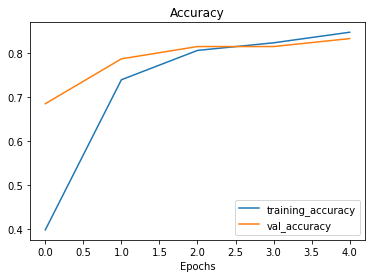

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from Trained Model  

Let's demonstrate the GlobalAveragePooling2D layer...  

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...  

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).  

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D. 

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Set random seed
tf.random.set_seed(42)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")  

# Pass the randon tensor through a GlobalAveragePoooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled Random Tensor: \n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D Tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Average Pooled Random Tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D Tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

`GlobalAveragePool2D` layer: Condenses th **input** found by the `base_model` into a *lower dimensional* **feature vector**.

🔨 **Practice:** Try to do the same with the above two cells, but this time use `GlobalMaxPool2D`...and see what happens.

In [ ]:
# Define input shape
input_shape = (1, 4, 4, 5)

# Set random seed
tf.random.set_seed(42)

# Create random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor: \n{input_tensor}\n")

# Passing the random input tensor through Global Max Pooling layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"Global Max Pooled Tensor: \n{global_max_pooled_tensor}\n")  

# Check the shape of the two tensors
print(f"Shape of input_tensor: {input_tensor.shape}")
print(f"Shape of Max Pooled Tensor: {global_max_pooled_tensor.shape}")

Random Input Tensor: 
[[[[ 3.27468514e-01 -8.42625797e-01  3.19433689e-01 -1.40755188e+00
    -2.38805985e+00]
   [-1.03924787e+00 -5.57323217e-01  5.39707005e-01  1.69943225e+00
     2.88936555e-01]
   [-1.50661159e+00 -2.64547408e-01 -5.97224057e-01 -1.91711318e+00
    -6.20441437e-01]
   [ 8.50402296e-01 -4.06047940e-01 -3.02584124e+00  9.05846417e-01
     2.98559874e-01]]

  [[-2.25615546e-01 -7.61644304e-01 -1.89171410e+00 -9.38471258e-01
     7.78522134e-01]
   [-4.73388970e-01  9.77726936e-01  2.46944040e-01  2.05737472e-01
    -5.25623322e-01]
   [ 3.24100167e-01  2.54540909e-02 -1.06384970e-01 -6.36947513e-01
     1.16031218e+00]
   [ 2.50735909e-01 -4.17285025e-01  4.01257813e-01 -1.41454434e+00
    -5.93185723e-01]]

  [[-1.66172135e+00  3.35671932e-01  1.08156286e-01  2.34796822e-01
    -5.66687644e-01]
   [-3.58198434e-01  8.86986136e-01  5.27447641e-01  7.04022467e-01
    -3.34212482e-01]
   [ 2.16396436e-01 -9.74854469e-01 -2.07576811e-01 -3.64772938e-02
    -1.33534443e

## **What is a Feature Vector?**  

A **Feature Vector** is  **learned representation of the input data** (a compressed form of the input data based on how the model see's it.)

## Running a series of Transfer Learning Experiments    

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...How about we setup a bunch of experiments to find out:  

1. `model_1` - Use **Feature Extraction Transfer Learning** with 1% of the training data with *data augmentation*.  
2. `model_2` - Use **Feature Extraction Transfer Learning** with 10% of the training data with *data augmentation*.  
3. `model_3` - Use **Fine-Tuning Transfer Learning** on 10% of the training data with data augmentation.  
4. `model_4` - Use **Fine-Tuning Transfer Learning** on 100% of the training data with *data augmentation*.

> 🔑 **Note:** Throughout all experiments the same test dataset will be used to evaluate our model...This ensures consistency across evaluation metrics.



## Getting and preprocessing data for `model_1`

In [ ]:
# Download and Unzip data - Preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data(filename="10_food_classes_1_percent.zip")

--2021-09-15 06:51:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   178MB/s    in 0.7s    

2021-09-15 06:51:14 (178 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"  

In [ ]:
# How many images are we working with?
walk_through_dir(dir_path="10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [ ]:
# Setup data loaders

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Previously, data augmentation used to be done with the `ImageDataGenerator` class.  

From TensorFlow 2.2+ onwards, the below technique can be used.

## Adding data augmentation right into the model  

To add data augmentation right into our models, we can use the layers inside:  

* `tf.keras.layers.experimental.preprocessing()`  

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers  

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:  

* Preprocessing of images (augmentation) happens on the GPU (much faster) than CPU.  
* Image Data Augmentation only happens during training, so we can still export our whole model and use it elsewhere.  
  * This means that when the data passes through the model for prediction, it does not get augmented.  

>INSHORT: When *DA* is passsed as a layer to a model, *DA* is automatically **turned on during training** but **turned off during inference**.   




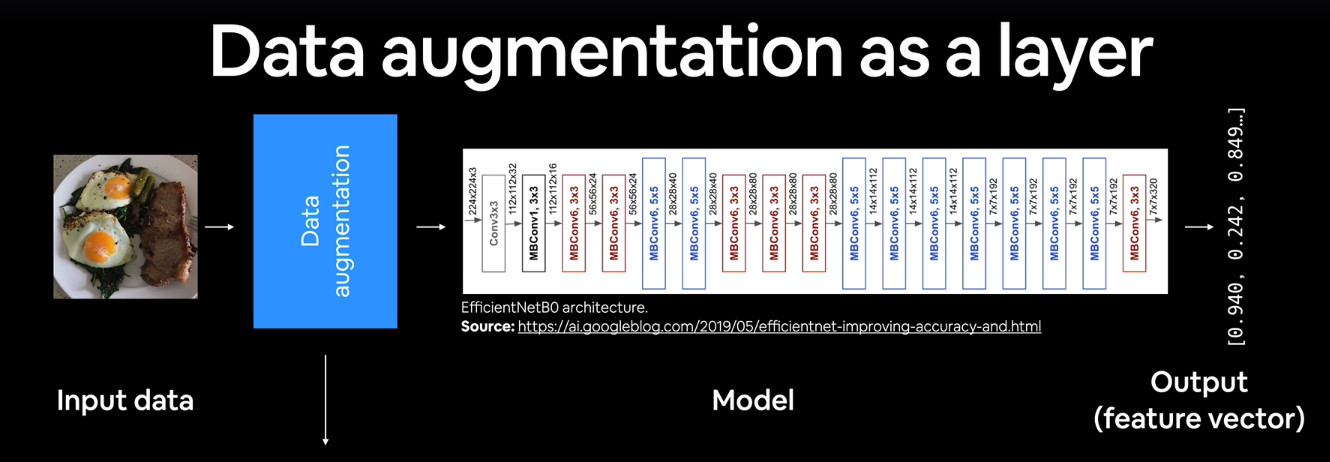

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing  

# Create Data Augmentation stage with horizontal flipping, rotations, zooms etc.  
'''
We can create a layer for our Functional API model using Sequential API
'''

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # Keep this for models like ResNet50V2, but EfficientNet's having rescaling built it.
], name="data_augmentation")  

### Visualize our data augmentation layer (and see what happens to our data)  


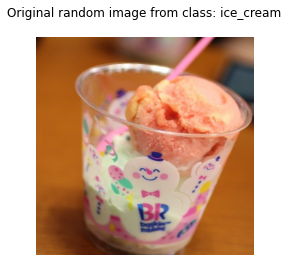

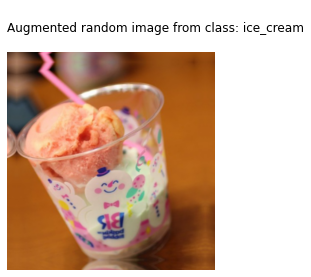

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}\n")
plt.axis(False);  

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.title(f"\nAugmented random image from class: {target_class}\n", loc="left")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img)/255.); # requires normalization after augmentation

In [ ]:
def view_random_image(dataset, split):
  '''
  Visualize a random image in batch dataset.

  `dataset`: Pass in the dataset you want to explore.  
  `split`: Specify data split

  '''
  if split not in ["train", "test"]:
    print(f'The "{str(dataset)}" dataset is split into only: {os.listdir(dataset)} sets.\n')
  target_data = dataset + f"/{split}/"
  class_names = os.listdir(f"{target_data}")
  target_class = random.choice(class_names)
  target_dir = target_data + target_class
  random_image = random.choice(os.listdir(target_dir))
  img = mpimg.imread(target_dir + "/" +random_image)
  plt.imshow(img)
  plt.title(f"Random image of class: {target_class}\n", loc="left")
  plt.axis("off");

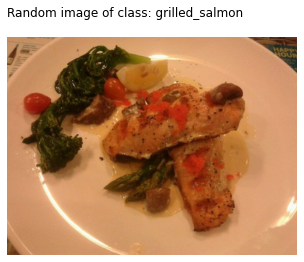

In [ ]:
view_random_image(dataset="10_food_classes_1_percent", split="train")

In [ ]:
os.listdir(f"10_food_classes_1_percent/train/")

['sushi',
 'chicken_curry',
 'ramen',
 'pizza',
 'ice_cream',
 'chicken_wings',
 'grilled_salmon',
 'fried_rice',
 'hamburger',
 'steak']

In [ ]:
os.listdir("10_food_classes_1_percent")

['train', 'test']

## Model 1: Feature Extraction Transfer Learning on 1% of the data with data augmentation

##### For Functional API:  

If it is a **whole model** pass it ➡️ (`inside`)  
If it is just a **layer** ➡️ ( )(`outside`)  

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")   

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)  

# Give `base_model` the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the `base_model`
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)  

# Put a dense layer on as the output
outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)  

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])  

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210915-065121
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 20s 5s/step - loss: 2.4183 - accuracy: 0.0714 - val_loss: 2.2185 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2079 - accuracy: 0.2429 - val_loss: 2.1106 - val_accuracy: 0.2303
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9196 - accuracy: 0.4571 - val_loss: 1.9991 - val_accuracy: 0.3289
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.7775 - accuracy: 0.5429 - val_loss: 1.8938 - val_accuracy: 0.4013
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.7060 - accuracy: 0.6714 - val_loss: 1.8267 - val_accuracy: 0.4227


In [ ]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
import tensorflow.keras.backend as K
import numpy as np
import math

def count_params(model):

  '''
  Args:
    `model`: Pass in TF model

  Returns:
  
  Total Parameters,
  Trainable Parameters,
  Non-Trainable Parameters
  '''

  trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
  non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

  print(f"Total params for: {math.ceil((trainable_count + non_trainable_count)):,}")
  print(f"Trainable params: {math.ceil(trainable_count):,}")
  print(f"Non-trainable params: {math.ceil(non_trainable_count):,}")

In [ ]:
count_params(model_1)

Total params for: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571


In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 14s 160ms/step - loss: 1.8242 - accuracy: 0.4352


[1.8242043256759644, 0.4352000057697296]

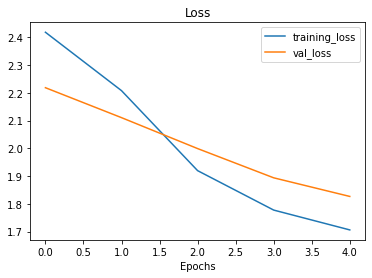

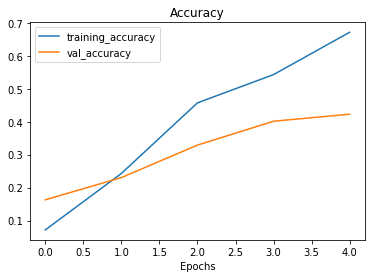

In [ ]:
# How do loss curves of the model with 1% of the data and data augmentation look?
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction Transfer Learning model with 10% of data and data augmentation

In [ ]:
# Get 10% of data (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"  

In [ ]:
# Set data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# How many images are there in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create model_2 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1/255.) # if you are using models like ResNet50V2, uncomment, EfficientNet has Rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called a backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False  

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")  

x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)

x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/

x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"])

### Creating a ModelCheckpoint callback
 
The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)

### Fit model_2 passing in the ModelCheckpoint callback


In [ ]:
# Fit the model saving checkpoints every epoch
'''
For Feature Extraction - Fit the model for 5 epochs
For Fine Tuning - Fit the model for another 5 epochs
'''

initial_epochs = 5 
 
history_model_2_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                                  epochs=initial_epochs,
                                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                         experiment_name="10_percent_data_aug"),
                                                             checkpoint_callback],
                                                  validation_data=test_data,
                                                  steps_per_epoch=len(train_data_10_percent),
                                                  validation_steps=int(0.25 * len(test_data)))

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210915-065242


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 2.0013 - accuracy: 0.3280 - val_loss: 1.4860 - val_accuracy: 0.6694

Epoch 00001: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 18s 715ms/step - loss: 1.3410 - accuracy: 0.6880 - val_loss: 1.0407 - val_accuracy: 0.7533

Epoch 00002: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 17s 672ms/step - loss: 1.0312 - accuracy: 0.7533 - val_loss: 0.8483 - val_accuracy: 0.7829

Epoch 00003: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 15s 585ms/step - loss: 0.9035 - accuracy: 0.7733 - val_loss: 0.7345 - val_accuracy: 0.8092

Epoch 00004: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 16s 647ms/step - loss: 0.8022 - accuracy: 0.7867 - v

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 13s 143ms/step - loss: 0.6133 - accuracy: 0.8376


[0.6133060455322266, 0.8375999927520752]

In [ ]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 12s 143ms/step - loss: 0.6946 - accuracy: 0.8104


[0.6945744156837463, 0.8104000091552734]

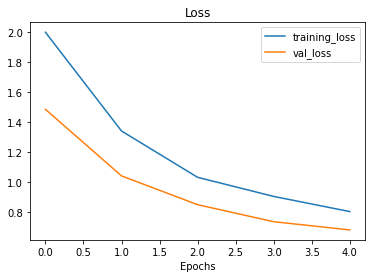

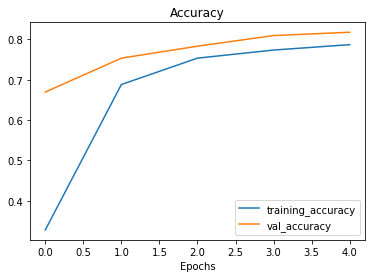

In [ ]:
# Plot model loss curves
plot_loss_curves(history_model_2_10_percent_data_aug)

### Loading in checkpointed weights  

Loading in checkpointed weights returns a model to a specific checkpoint.  

___________________________________________________________

Load in **saved weights**, in to a model, make predictions, and check if evaluation metrics match previous prediction results.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
checkpoint_path

'10_percent_model_checkpoints_weights/checkpoint.ckpt'

In [ ]:
# Evaluate model_2 with loaded weights 
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 12s 141ms/step - loss: 0.6946 - accuracy: 0.8104


If the results from our previously evaluated model_2, match the loaded weights, everything has worked.

In [ ]:
# Check to see if the loaded model reuslts are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


This minor difference is because how computers store numbers.

In [ ]:
loaded_weights_model_results

[0.6945743560791016, 0.8104000091552734]

## Model 3: Fine-Tuning an existing model on 10% of the data   

> 🔑 **Note:** Fine-tuning usually works best **after** training a **Feature Extraction** model for a few epochs with large amounts of custom data.

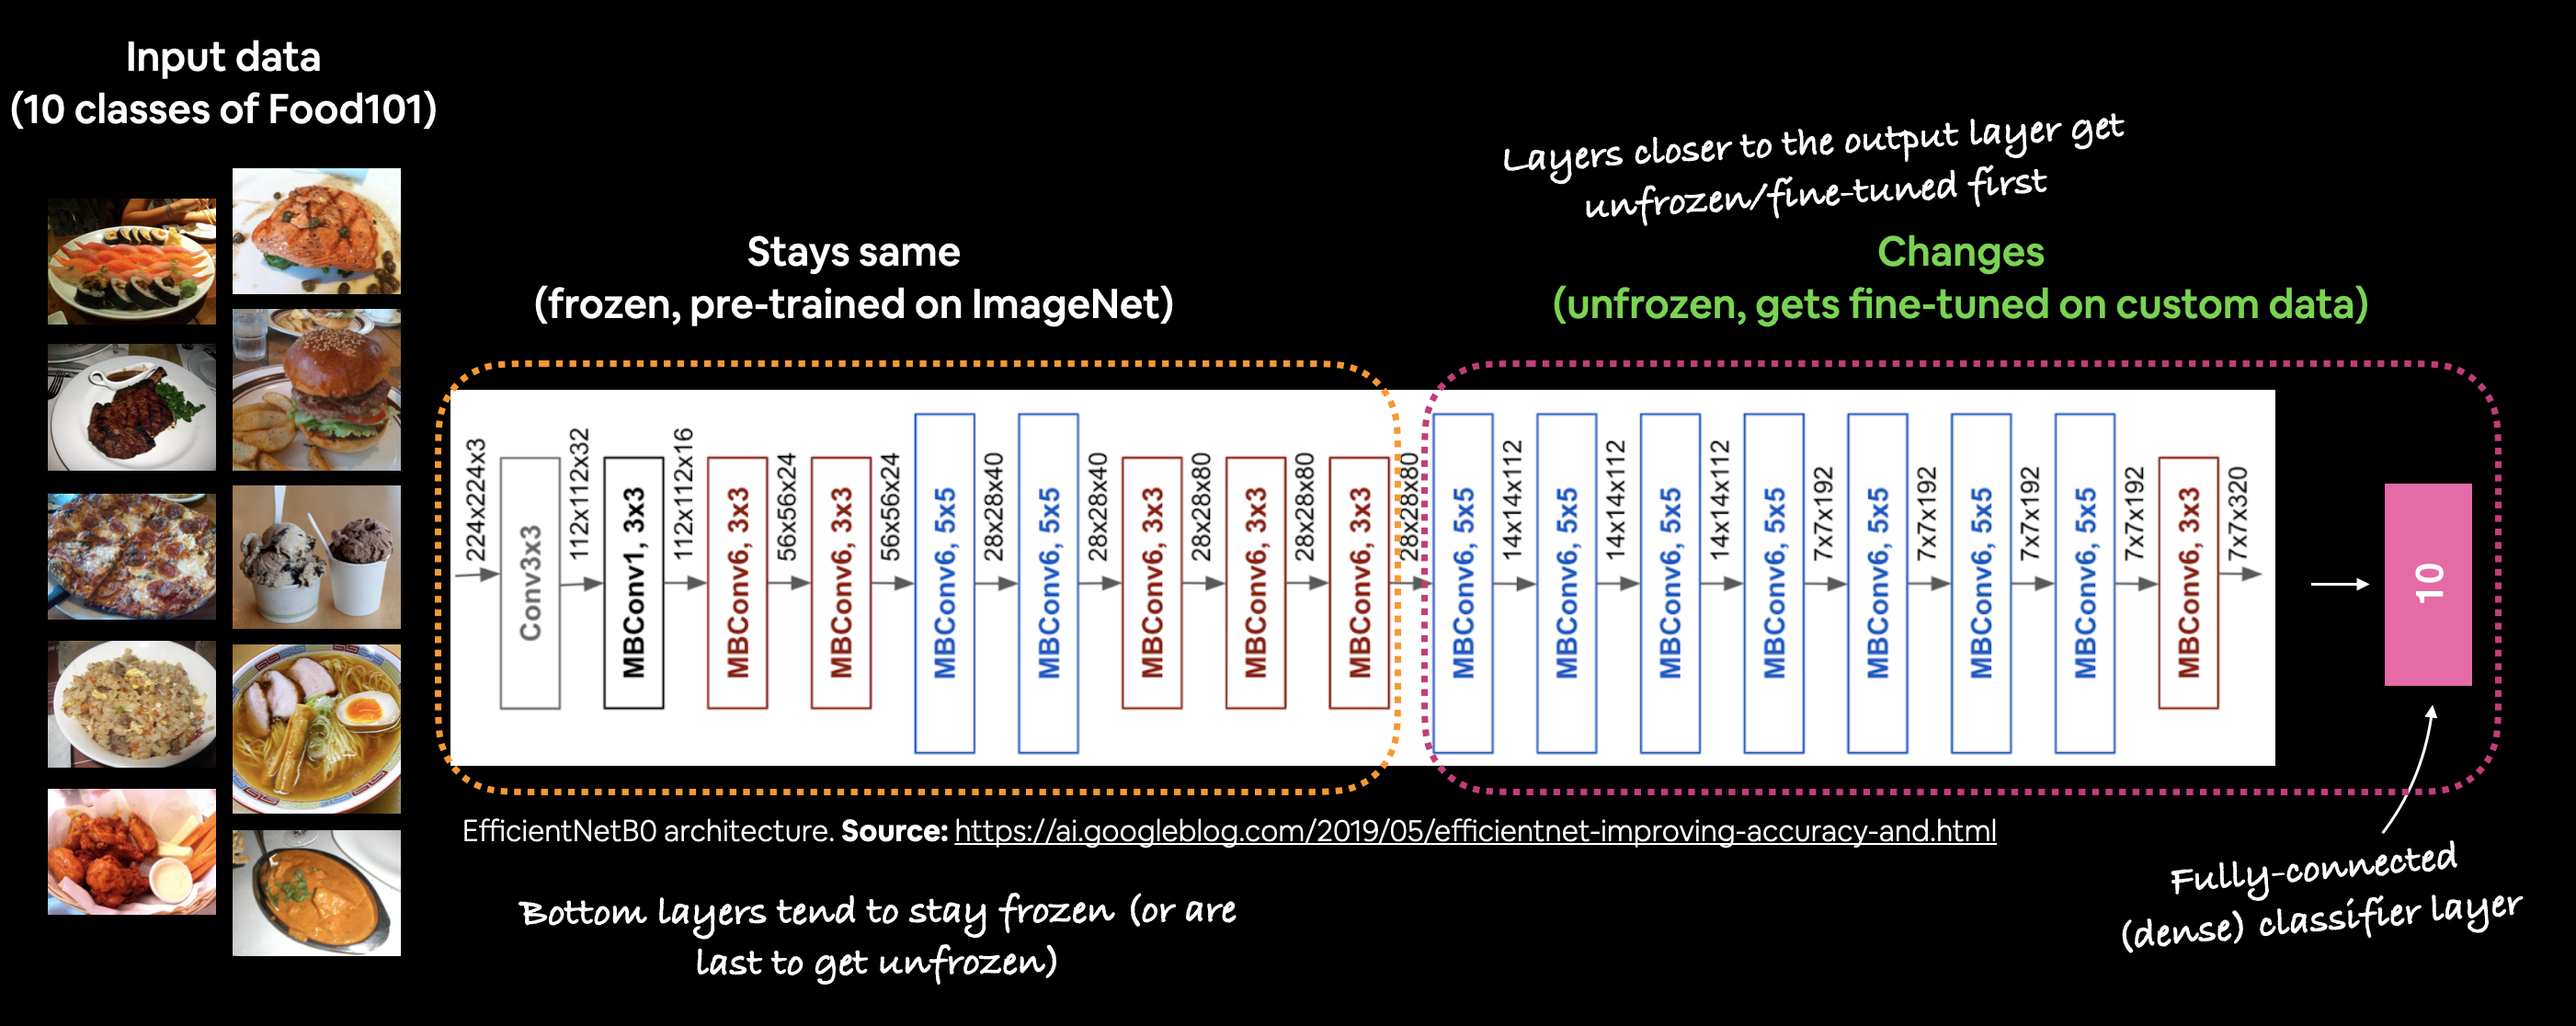









While **Fine-Tuning** generally unfreeze layers closer to the top (output_layer), as layers closer to the input learn more *general* features such as shapes etc.   

In [ ]:
# Layers in a Loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9fc60e7390> True
<keras.engine.sequential.Sequential object at 0x7f9fc530cd90> True
<keras.engine.functional.Functional object at 0x7f9fc5bc2710> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9fc614e810> True
<keras.layers.core.Dense object at 0x7f9fc5badfd0> True


In [ ]:
def trainable_layers(model):
  '''
  Args:
    `model`: Pass in a TF model.

  Returns:
  
    `tabulate` Table with headers: No., Layer Name, Trainable
  
  --Index - Index Position of Layer
  --Name - Layer name, user defined in parameter `name`
  --Trainable - Boolean, (`True` - Trainable, `False` - Non-Trainable/Frozen)   
  
  Imports:  

    `from tabulate import tabulate`
  '''
  from tabulate import tabulate
  layer_num = []
  layer_name = []
  layer_trainable = []
  headers = ["Index", "Layer Name", "Trainable"]
  for i, layer in enumerate(model.layers):
    layer_num.append(i)
    layer_name.append(layer.name)
    layer_trainable.append(layer.trainable)

  table = zip(layer_num, layer_name, layer_trainable)
  print(tabulate(table, headers=headers, tablefmt="orgtbl"))

In [ ]:
set_cell_size()
trainable_layers(model_2.layers[2])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_3                   | False       |
|       1 | rescaling_2               | False       |
|       2 | normalization_2           | False       |
|       3 | stem_conv_pad             | False       |
|       4 | stem_conv                 | False       |
|       5 | stem_bn                   | False       |
|       6 | stem_activation           | False       |
|       7 | block1a_dwconv            | False       |
|       8 | block1a_bn                | False       |
|       9 | block1a_activation        | False       |
|      10 | block1a_se_squeeze        | False       |
|      11 | block1a_se_reshape        | False       |
|      12 | block1a_se_reduce         | False       |
|      13 | block1a_se_expand         | False       |
|      14 | block1a_se_excite         | False       |
|      15 | block1a_project_conv      | False       |
|      16 | block1a_project_

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin Fine-Tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])

####**Rule for Fine-Tuning:**

Because we are *updating* already **learned weights** in an existing model, we don't want those *weights* to be updated too much.  

**Learning Rate:** Dictates how much a model updates its internal patterns or internal weights (epoch-to-epoch) / (sample-to-sample) based on the loss function as well as the optimizer.  

Because the *unfrozen* layers have already learned patterns from the *original dataset*, we don't want to too drastically change those patterns b/c that's going to result in overfitting.  

**Rule of Thumb:** Lower the **Learning Rate** by **10x**. (This is a *hyperparameter* you can tune on your own)  

📖 **Resource:** [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146)

In [ ]:
# Check which layers are tunable(trainable)?
set_cell_size()
trainable_layers(model_2.layers[2])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_3                   | False       |
|       1 | rescaling_2               | False       |
|       2 | normalization_2           | False       |
|       3 | stem_conv_pad             | False       |
|       4 | stem_conv                 | False       |
|       5 | stem_bn                   | False       |
|       6 | stem_activation           | False       |
|       7 | block1a_dwconv            | False       |
|       8 | block1a_bn                | False       |
|       9 | block1a_activation        | False       |
|      10 | block1a_se_squeeze        | False       |
|      11 | block1a_se_reshape        | False       |
|      12 | block1a_se_reduce         | False       |
|      13 | block1a_se_expand         | False       |
|      14 | block1a_se_excite         | False       |
|      15 | block1a_project_conv      | False       |
|      16 | block1a_project_

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.layers[2].trainable_variables))

10


In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5 # for another 5 epochs

# Refit the model (same as model_2 except with more trainable layers)
history_model_2_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                                       epochs=fine_tune_epochs,
                                                       validation_data=test_data,
                                                       steps_per_epoch=len(train_data_10_percent),
                                                       validation_steps=int(0.25 * len(test_data)),
                                                       initial_epoch=history_model_2_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                                       callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                              experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210915-065536


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
24/24 [==============================] - 37s 937ms/step - loss: 0.6831 - accuracy: 0.7907 - val_loss: 0.5359 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 19s 746ms/step - loss: 0.5455 - accuracy: 0.8427 - val_loss: 0.5370 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - 16s 630ms/step - loss: 0.4936 - accuracy: 0.8533 - val_loss: 0.5050 - val_accuracy: 0.8224
Epoch 8/10
24/24 [==============================] - 16s 668ms/step - loss: 0.4451 - accuracy: 0.8653 - val_loss: 0.4868 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 16s 630ms/step - loss: 0.4393 - accuracy: 0.8627 - val_loss: 0.4405 - val_accuracy: 0.8536
Epoch 10/10
24/24 [==============================] - 15s 585ms/step - loss: 0.3957 - accuracy: 0.8680 - val_loss: 0.4629 - val_accuracy: 0.8372


*Fine-tuning* typically takes longer than *Feature Extraction*, b/c there are more layers to update.

In [ ]:
# Evalute the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 12s 141ms/step - loss: 0.5018 - accuracy: 0.8300


In [ ]:
results_10_percent_data_aug

[0.6945744156837463, 0.8104000091552734]

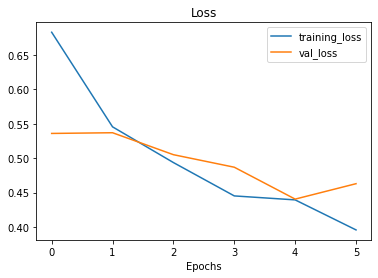

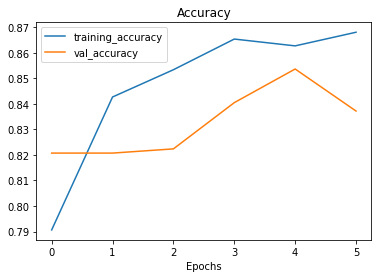

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history=history_model_2_fine_10_percent_data_aug)

The above loss curves are for 5 epochs. An updated version of plot_loss_curves that shows before fine-tuning and after fine-tuning is necessary.    

The `plot_loss_curves` function works great with models which have only been fit once, however we want something to compare one series of running `fit()` with another (e.g before and after fine-tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow Model History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

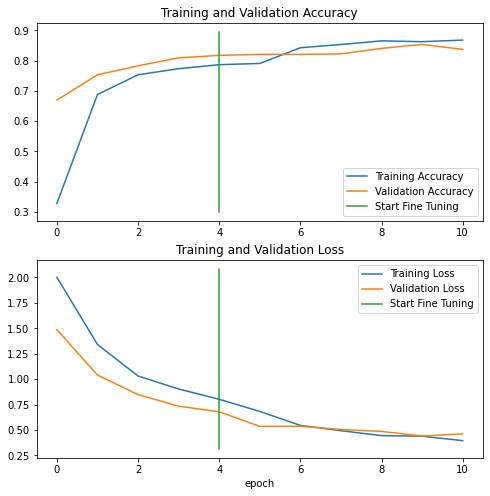

In [ ]:
compare_historys(history_model_2_10_percent_data_aug, history_model_2_fine_10_percent_data_aug, initial_epochs)

*Fine-Tuning* often requires more data.

## Model 4: Fine-Tuning and exisiting model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-09-15 06:58:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 142.250.152.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  95.7MB/s    in 5.1s    

2021-09-15 06:58:15 (96.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [ ]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded-in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).  

Let's verify this...

In [ ]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 13s 151ms/step - loss: 0.5018 - accuracy: 0.8300


[0.5018073320388794, 0.8299999833106995]

In [ ]:
results_fine_tune_10_percent

[0.501807451248169, 0.8299999833106995]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load model from checkpoint, that we can fine-tune from the same stage
# the 10 percent data model was fine-tuned from 

model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate the model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 13s 153ms/step - loss: 0.6946 - accuracy: 0.8104


[0.6945744156837463, 0.8104000091552734]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6945744156837463, 0.8104000091552734]

The previous steps might seem quite confusing, but all we've done is:  

1. Trained a Feature Extraction Transfer Learning Model for *5 epochs* on 10% of the data with data augmentation. (model_2) and we saved the model's weight using `ModelCheckpoint` callback.  

2. Fine-Tuned the same model on the same 10% of the data for a further *5 epochs* with the top 10 layers of the base model unfrozen (model_3)  

3. Saved the results and training logs each time.  
4. Reloaded the model from *step 1* to do the same steps as *step 2* except this time we're going to use all of the data (model_4).


In [ ]:
# Check which layers are tunable in the whole model
trainable_layers(model_2)

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_layer               | True        |
|       1 | data_augmentation         | True        |
|       2 | efficientnetb0            | True        |
|       3 | global_average_pooling_2D | True        |
|       4 | output_layer              | True        |


In [ ]:
set_cell_size()

# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
trainable_layers(model_2.layers[2])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_3                   | False       |
|       1 | rescaling_2               | False       |
|       2 | normalization_2           | False       |
|       3 | stem_conv_pad             | False       |
|       4 | stem_conv                 | False       |
|       5 | stem_bn                   | False       |
|       6 | stem_activation           | False       |
|       7 | block1a_dwconv            | False       |
|       8 | block1a_bn                | False       |
|       9 | block1a_activation        | False       |
|      10 | block1a_se_squeeze        | False       |
|      11 | block1a_se_reshape        | False       |
|      12 | block1a_se_reduce         | False       |
|      13 | block1a_se_expand         | False       |
|      14 | block1a_se_excite         | False       |
|      15 | block1a_project_conv      | False       |
|      16 | block1a_project_

We've made a change to our model, which means, we have to **compile**.

In [ ]:
# Compile
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lowered by 10x for Fine-Tuning
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"])  

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5  

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           steps_per_epoch=len(train_data_10_classes_full),
                                           initial_epoch=history_model_2_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210915-065949


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
235/235 [==============================] - 85s 302ms/step - loss: 0.7414 - accuracy: 0.7671 - val_loss: 0.4233 - val_accuracy: 0.8618
Epoch 6/10
235/235 [==============================] - 90s 379ms/step - loss: 0.5979 - accuracy: 0.8081 - val_loss: 0.3820 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - 82s 344ms/step - loss: 0.5325 - accuracy: 0.8245 - val_loss: 0.3352 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 78s 328ms/step - loss: 0.4973 - accuracy: 0.8387 - val_loss: 0.3704 - val_accuracy: 0.8684
Epoch 9/10
235/235 [==============================] - 75s 317ms/step - loss: 0.4473 - accuracy: 0.8544 - val_loss: 0.3331 - val_accuracy: 0.8865
Epoch 10/10
235/235 [==============================] - 72s 303ms/step - loss: 0.4196 - accuracy: 0.8640 - val_loss: 0.3244 - val_accuracy: 0.8832


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 129ms/step - loss: 0.3123 - accuracy: 0.8984


[0.3123374283313751, 0.8984000086784363]

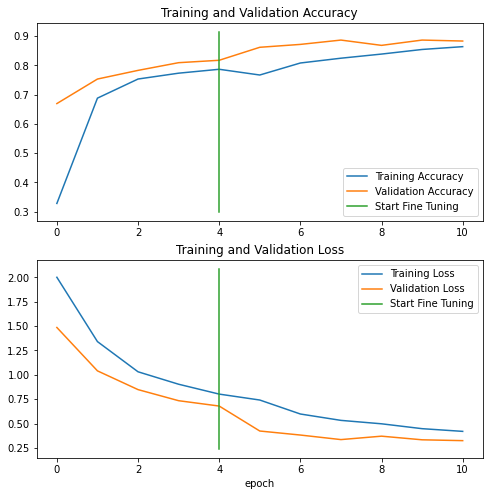

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_model_2_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard  

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.  


In [ ]:
# View TensorBoard logs of Transfer Learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different Transfer Learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # Exits the uploader once its finished uploading

2021-09-15 07:23:25.788710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 07:23:25.800847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 07:23:25.801671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Priv

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/pLYnr5SMR6y3LhyR5tqkSQ/

In [ ]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

2021-09-15 07:41:24.996495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 07:41:25.005616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 07:41:25.006332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/pLYnr5SMR6y3LhyR5tqkSQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different Transfer Learning experiments with varying amounts of data and fine-tuning.
	Id                   pLYnr5SMR6y3LhyR5tqkSQ
	Created              2021-09-15 07:23:4

In [ ]:
# To delete an experiment   
# !tensorboard dev delete --experiment_id pLYnr5SMR6y3LhyR5tqkSQ